# EECS 598 Lab 4: Domain Randomization and Terrain Generation

![lab4_poster](./media/lab4_poster.png)

This notebook is worth **80 points**. Questions and implementation are marked with relevent `#TODO(student)` markers.

Before starting the assignment, please put your name and UMID in the following format:

Firstname LASTNAME, #00000000 (ex. Drew SCHEFFER #31415926)

**YOUR ANSWER**

SHIVAM UDESHI, 87841376

## Setup

In [2]:
import sys, types, importlib

# Create a tiny fake 'imp' module exposing only 'reload'
_imp = types.ModuleType("imp")
_imp.reload = importlib.reload
sys.modules["imp"] = _imp

# load autoreload
%load_ext autoreload
%autoreload 2

In [3]:
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [4]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.5 MB/s eta 0:00:00


### Google Colab Setup

Next, we'll run a few fommands to set up the environment on Google Colab. If you are running this notebook locally you can skip this section

Run the following to mount this notebook to your Google Drive. Follow the link and sign into the Google account following the prompts. Use the same Google account that you used to store this notebook.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now update the path below to point to the folder in your Google Drive where you uploaded this notebook. If everything worked correctly you should see the following filenames: [`custom_env.py`, `02_lab.ipynb`]

In [6]:
import os

# TODO: Fill in the Google Drive path where you uploaded project 2
# Example: If you create a 2025FA folder and put all the files under Lab4, then '2025FA/Lab4'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2025FA/Lab4'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization'
GOOGLE_DRIVE_PATH_LAB3 = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_PATH_LAB3))

['.DS_Store', 'google_barkour_vb', 'media', '__pycache__', 'custom_env.py', 'terrain_generator_student.py', 'WFC_Project', '04_lab_student.ipynb']


In [7]:
from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")



Ensure that everything is installed properly

In [8]:
import os
!pip install mujoco

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 130.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 28.1 MB/s eta 0:00:00
Checking that the installation succeeded:
Installation successful.


## Mujoco Setup & Imports

In [9]:
!pip install mujoco
!pip install mujoco_mjx
!pip install brax
!pip install noise

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.1/729.1 kB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.1/344.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp312-cp312-linux_x86_64.whl size=56630 sha256=9fadd6311d78fa1149eb514b56a3454350932781b935cc1e4db2304d01ec8f08
  Stored in directory: /root/.cache/pip/wheels/78/71/a2/47a0c6acdeb8f7a2f4e69067d3c737219e36414136441a1ef8
Successfully built noise


In [11]:
#@title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
import os
from ml_collections import config_dict


import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

import cv2

## Randomizing Model Properties in Mujoco Playground

We might want to include randomization over certain `mjModel` parameters while training different policies. In MJX, we can easily create a **batch** of environments with randomized values populated in `mjx.Model`. Below, you will impliment a simple function that randomizes friction and actuator gain/bias.

`TODO(student):` Impliment the function below to randomize friction in the environment **(10 pts)**

In [ ]:
def domain_randomize(sys, rng):
  """Randomizes the mjx.Model."""

  @jax.vmap
  def rand(rng):
    '''
    Returns randomized friction and actuator parameters.
    '''
    # split key
    key, subkey = jax.random.split(rng)

    # --- friction randomization ---
    # Sample scaling factors in [0.6, 1.4] for each geom
    friction_scale = jax.random.uniform(
        subkey, sys.geom_friction.shape, minval=0.6, maxval=1.4
    )
    friction = sys.geom_friction * friction_scale

    # --- actuator randomization (already given) ---
    key, subkey = jax.random.split(key)
    gain_range = (-5, 5)
    param = jax.random.uniform(
        subkey, (1,), minval=gain_range[0], maxval=gain_range[1]
    ) + sys.actuator_gainprm[:, 0]
    gain = sys.actuator_gainprm.at[:, 0].set(param)
    bias = sys.actuator_biasprm.at[:, 1].set(-param)

    return friction, gain, bias

  # call vmapped rand
  friction, gain, bias = rand(rng)

  # set which fields will vary across batch
  in_axes = jax.tree_util.tree_map(lambda x: None, sys)
  in_axes = in_axes.tree_replace({
      'geom_friction': 0,
      'actuator_gainprm': 0,
      'actuator_biasprm': 0,
  })

  # replace sys values with randomized ones
  sys = sys.tree_replace({
      'geom_friction': friction,
      'actuator_gainprm': gain,
      'actuator_biasprm': bias,
  })

  return sys, in_axes


In [ ]:
import os, sys
sys.path.append('/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization')
from custom_env import GoogleBarkourEnv
envs.register_environment('barkour', GoogleBarkourEnv)
env = envs.get_environment("barkour")

rng = jax.random.PRNGKey(0)
rng = jax.random.split(rng, 10)
batched_sys, _ = domain_randomize(env.sys, rng)

print('Single env friction shape: ', env.sys.geom_friction.shape)
print('Batched env friction shape: ', batched_sys.geom_friction.shape)

print('Friction on geom 0: ', env.sys.geom_friction[0, 0])
print('Random frictions on geom 0: ', batched_sys.geom_friction[:, 0, 0])

/usr/local/lib/python3.12/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


Single env friction shape:  (30, 3)
Batched env friction shape:  (10, 30, 3)
Friction on geom 0:  1.0
Random frictions on geom 0:  [0.683 0.673 1.197 1.279 1.088 1.398 0.9   0.611 0.766 0.65 ]


`TODO(student):` Explain in your own words what the `@jax.vmap` decorator does in the above code: **(10 pts)**

**Answer:** The @jax.vmap decorator in the code automatically vectorizes the rand function so it can be applied over batches of random keys in parallel without writing explicit loops. Instead of handling one input at a time, vmap lifts the function to operate efficiently across arrays using JAX's optimized parallel execution. In this context, it allows generating randomized friction and actuator parameters for multiple samples at once.

## Procedurally Generating Terrain

In this section, we'll explore how to procedurally generate terrains to spawn in our environment. We will do this by modifying the [`scene_mjx.xml`](./google_barkour_vb/barkour_vb_mjx.xml) files provided in this lab. First, you'll create a modular "terrain element builder" which is capable of procedurally generating terrain elements (i.e. slopes, heightfields, boxes, cyllinders, and stairs). Next, we'll explore how to intelligently place these scene elements in the scene

First, let's render a simple environment with a good view of the entire scene.

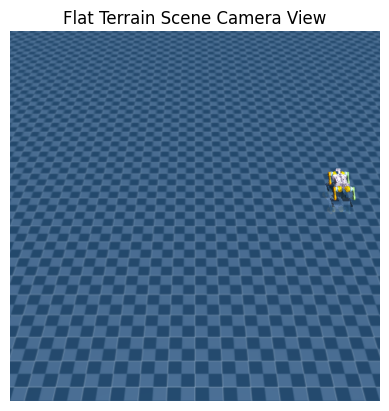

In [ ]:
from custom_env import GoogleBarkourEnv
envs.register_environment('barkour', GoogleBarkourEnv)
env = envs.get_environment("barkour")

# jit reset/step functions for fast runtime
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

state = jit_reset(jax.random.PRNGKey(0))

img = env.render([state.pipeline_state], camera='scene', width=480, height=480)[0]
plt.imshow(img)
plt.title("Flat Terrain Scene Camera View")
plt.axis("off")
plt.show()

`TODO(student): `Impliment at least (2/5) "TODOs" in the [`terrain_generator.py`](./terrain_generator.py) file. You can use the next code blocks to generate a modified XML using the `TerrainGenerator` class. **(20 pts)**

In [ ]:
# TODO: impliment the todos in the terrain_generator.py file to procedurally generate terrain

from terrain_generator_student import TerrainGenerator

input_scene_path = "/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/google_barkour_vb/scene_mjx.xml"
output_scene_path = "/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/google_barkour_vb/scene_mjx_with_terrain.xml"
tg = TerrainGenerator(input_scene_path, output_scene_path)

# Box obstacle
tg.AddBox(position=[1.5, 0.0, 0.1], euler=[0, 0, 0.0], size=[1, 1.5, 0.2])

# Geometry obstacle
# geo_type supports "plane", "sphere", "capsule", "ellipsoid", "cylinder", "box"
tg.AddGeometry(position=[1.5, 0.0, 0.25], euler=[0, 0, 0.0], size=[1.0,0.5,0.5],geo_type="cylinder")

# Slope
tg.AddBox(position=[2.0, 2.0, 0.5],
            euler=[0.0, -0.5, 0.0],
            size=[3, 1.5, 0.1])

# Stairs
tg.AddStairs(init_pos=[1.0, 4.0, 0.0], yaw=0.0)

# Rough ground
tg.AddRoughGround(init_pos=[-2.5, 5.0, 0.0],
                    euler=[0, 0, 0.0],
                    nums=[10, 8])

# Perlin heigh field
tg.AddPerlinHeighField(position=[-1.5, 3.5, 0.0], size=[2.0, 1.5])

# Heigh field from image
tg.AddHeighFieldFromImage(position=[-1.5, 2.0, 0.0],
                          euler=[0, 0, -1.57],
                          size=[1.0,1.0],
                          input_img="./unitree_robot.jpeg",
                          image_scale=[0.5, 0.5],
                          output_hfield_image="unitree_hfield.png")

# CustomTerrain
tg.CustomTerrain(init_pos=[1.0, 6.0, 0.0], yaw=0.0)


tg.Save()




Implimented: AddStairs
Implimented: AddRoughGround
Implimented: AddPerlinHeighField
Implimented: AddHeighFieldFromImage
Implimented: CustomTerrain


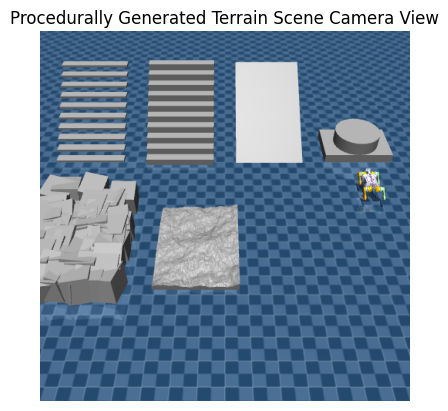

In [ ]:
env = envs.get_environment("barkour", scene_file="scene_mjx_with_terrain.xml")

# jit reset/step functions for fast runtime
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

state = jit_reset(jax.random.PRNGKey(0))

img = env.render([state.pipeline_state], camera='scene', width=480, height=480)[0]
plt.imshow(img)
plt.title("Procedurally Generated Terrain Scene Camera View")
plt.axis("off")
plt.show()

## Generating Terrain with Contraints (Wave Function Collapse)

In this section, we'll use a cool method called Wave Function Collapse (WFC) to create custom, procedurally generated terrains for our environment! To get a high-level understanding of what this looks like, take a look at the popular git repo [https://github.com/mxgmn/WaveFunctionCollapse](https://github.com/mxgmn/WaveFunctionCollapse).
Interestingly, one of the main use-cases for this algorithm is in computer games for self-generating maps and levels. The algorithm works by creating large output images that are "locally similar" to some small input pattern.

![bitmap_illustration](/content/drive/MyDrive/CSE598_Action_Perception/Lab/lab4-terrain-randomization/media/bitmap_illustration.png)

The basic implementation of the algorithm generates **bitmap images**. One idea is to use these novel, generated bitmaps to define where to place different terrain elements in the scene (i.e. boxes, walls, stairs, etc). Ideally, this procedure would help make more structured, yet random environments for the robot to explore.

Note: there are also implementations that generate "tilemaps", however, they typically require the user to explicitly generate contraints between tiles (which is a bit too time consuming for this lab). You can read more at [https://github.com/mxgmn/WaveFunctionCollapse](https://github.com/mxgmn/WaveFunctionCollapse).

In [ ]:
# TODO: Create your own bitmap pattern
from PIL import Image
import numpy as np

def bitmap_string_to_image(bitmap_str, output_path="bitmap_image.png"):
    lines = bitmap_str.strip().split("\n")
    height = len(lines)
    width = len(lines[0])

    # Create a numpy array
    img_array = np.zeros((height, width), dtype=np.uint8)

    # Fill array with integers
    for i, line in enumerate(lines):
        img_array[i] = [int(ch) for ch in line]

    # Define fixed color map: e.g., 0=white, 1=black, 2=red, 3=green, 4=blue
    color_palette = [
        (255, 255, 255),  # 0 - white
        (0, 0, 0),        # 1 - black
        (255, 0, 0),      # 2 - red
        (0, 255, 0),      # 3 - green
        (0, 0, 255)       # 4 - blue
    ]

    rgb_img = np.zeros((height, width, 3), dtype=np.uint8)
    unique_values = np.unique(img_array)

    for val in unique_values:
        color = color_palette[val % len(color_palette)]
        mask = img_array == val
        rgb_img[mask] = color

    # Create and save image
    img = Image.fromarray(rgb_img, "RGB")
    output_path = '/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/media/output.png'
    img.save(output_path)
    print(f"Image saved to {output_path}")

    return img





Image saved to /content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/media/output.png


/tmp/ipython-input-2598225200.py:35: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(rgb_img, "RGB")


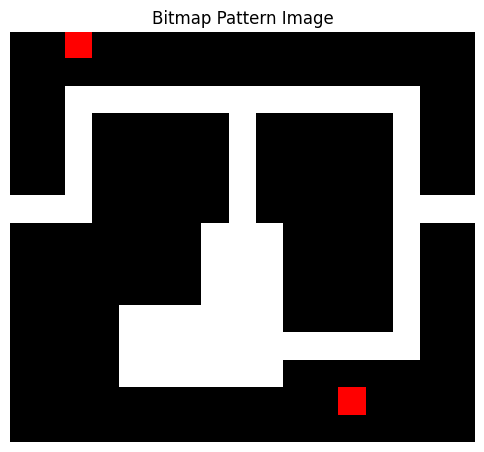

In [ ]:
# TODO: play around with and change this pattern! Use any integers 0-4.
import matplotlib.pyplot as plt


bitmap_pattern_str = """
11211111111111111
11111111111111111
11000000000000011
11011111011111011
11011111011111011
11011111011111011
00011111011111000
11111110001111011
11111110001111011
11111110001111011
11110000001111011
11110000000000011
11110000001111111
11111111111121111
11111111111111111
"""

img = bitmap_string_to_image(bitmap_pattern_str, "out_bitmap.png")
plt.figure(figsize=(6,6))  # bigger display window
plt.imshow(img, cmap="gray", interpolation="nearest")
plt.title("Bitmap Pattern Image")
plt.axis("off")
plt.show()


### Generate Random Bitmaps using Your Pattern

`TODO(student):` Use the initial pattern that you just created to generate a larger output bitmap. **(40 pts)**

To do this, use [this python implimentation of the Wave Function Collapse algorithm](https://github.com/ikarth/wfc_2019f?tab=readme-ov-file). Follow along with the readme to understand how to add your own custom patterns. I've found it best to just do this task on your local computer.  

Running WFC with params: {'filename': None, 'tile_size': 1, 'pattern_width': 3, 'rotations': 8, 'output_size': [64, 64], 'ground': None, 'attempt_limit': 10, 'output_periodic': True, 'input_periodic': True, 'loc_heuristic': 'entropy', 'choice_heuristic': 'weighted', 'visualize': False, 'global_constraint': False, 'backtracking': False, 'log_filename': 'wfc_log', 'logging': False, 'log_stats_to_output': None}
✅ WFC output saved: /content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/media/output_final.png


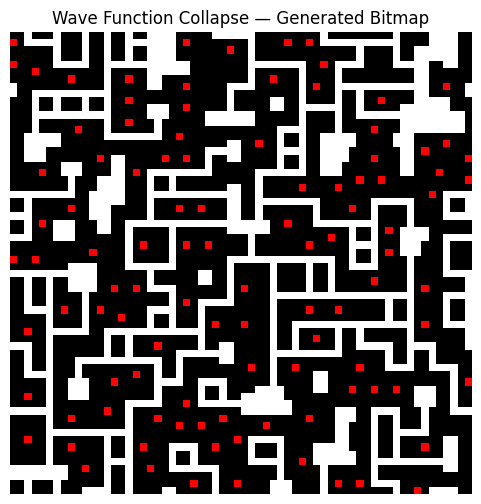

In [ ]:
# ====================================================
# Generate Random Bitmap using Wave Function Collapse
# Correct: pass NumPy array for `image`
# ====================================================

import os, sys
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Path to repo root
REPO_ROOT = "/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/WFC_Project/wfc_2019f"
if REPO_ROOT not in sys.path:
    sys.path.append(REPO_ROOT)

from wfc import wfc_control

# Input pattern (your own or repo sample)
input_pattern = os.path.join(REPO_ROOT, "/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/media", "output.png")
assert os.path.isfile(input_pattern), f"Pattern not found: {input_pattern}"

# Convert input image → numpy array
pattern_img = Image.open(input_pattern).convert("RGB")
pattern_array = np.array(pattern_img)

# Output path
output_path = "/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/media/output_final.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Parameters (image = NumPy array!)
params = dict(
    filename=None,
    tile_size=1,
    pattern_width=3,
    rotations=8,
    output_size=[64, 64],
    ground=None,
    attempt_limit=10,
    output_periodic=True,
    input_periodic=True,
    loc_heuristic="entropy",
    choice_heuristic="weighted",
    visualize=False,
    global_constraint=False,
    backtracking=False,
    log_filename="wfc_log",
    logging=False,
    log_stats_to_output=None,
    image=pattern_array
)

print("Running WFC with params:", {k:v for k,v in params.items() if k!="image"})

# Run WFC
bitmap = wfc_control.execute_wfc(**params)

# Save and show
if isinstance(bitmap, np.ndarray):
    Image.fromarray(bitmap.astype(np.uint8)).save(output_path)
    print("WFC output saved:", output_path)

    plt.figure(figsize=(6,6))
    plt.imshow(bitmap.astype(np.uint8))
    plt.axis("off")
    plt.title("Wave Function Collapse — Generated Bitmap")
    plt.show()
else:
    raise RuntimeError("WFC did not return an image array.")


### Use Your Procedurally Generated Bitmap to Influence the Mujoco Terrain

`TODO(student):` Somehow use your generated bitmap to influence the terrain in some way using the `TerrainGenerator` class you implimented in the previous section. **(40 pts)**

There are many ways to do this, here are a few ideas:
1. come up with a mapping from pixels to world locations and spawn different terrain elements for different pixel values
2. simply interpret the bitmap image as a heightmap in the `TerrainGenerator`


In [ ]:
from PIL import Image
import numpy as np
from terrain_generator_student import TerrainGenerator

# Input/Output scene XMLs
input_scene = "/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/google_barkour_vb/scene_mjx.xml"
output_scene = "/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/media/scene_with_bitmap.xml"

# Create terrain generator with scene paths
terrain_gen = TerrainGenerator(input_scene, output_scene)

# Load generated bitmap
bitmap_path = "/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/media/output_final.png"
bitmap = Image.open(bitmap_path).convert("L")   # grayscale
bitmap_data = np.array(bitmap)

# Scale factors: 1 pixel → 0.05 meters
scale = 0.05

for y in range(bitmap_data.shape[0]):
    for x in range(bitmap_data.shape[1]):
        val = bitmap_data[y, x]   # 0..255

        # Map brightness → block height
        if val < 85:
            h = 0.2
        elif val < 170:
            h = 0.1
        else:
            h = 0.0

        if h > 0:
            terrain_gen.AddBox(
                position=[x * scale, y * scale, h / 2.0],
                euler=[0, 0, 0],
                size=[scale / 2.0, scale / 2.0, h / 2.0]
            )

# Write out the modified XML
terrain_gen.Save()

print(f"✅ Terrain generated from bitmap and saved to {output_scene}")



✅ Terrain generated from bitmap and saved to /content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/media/scene_with_bitmap.xml


In [ ]:
from terrain_generator_student import TerrainGenerator

# Paths
input_scene_path = "/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/google_barkour_vb/scene_mjx.xml"
output_scene_path = "/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/google_barkour_vb/scene_mjx_with_bitmap.xml"
bitmap_path = "/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/media/output_final.png"

# Initialize generator
tg = TerrainGenerator(input_scene_path, output_scene_path)

# Use the generated bitmap as a heightfield
tg.AddHeighFieldFromImage(
    position=[0.0, 0.0, 0.0],       # world location of the heightfield
    euler=[0.0, 0.0, 0.0],          # orientation (flat)
    size=[4.0, 4.0],                # physical size in Mujoco world (x,y extent)
    height_scale=0.2,               # exaggeration of elevation
    negative_height=0.0,            # baseline clipping
    input_img=bitmap_path,          # your WFC bitmap
    output_hfield_image="bitmap_hfield.png",
    image_scale=[0.25, 0.25],       # resolution of sampling
    invert_gray=True                # flip if hills/valleys look reversed
)

# Save the new scene
tg.Save()
print("Bitmap-based terrain generated and saved to", output_scene_path)


Implimented: AddHeighFieldFromImage
Bitmap-based terrain generated and saved to /content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/google_barkour_vb/scene_mjx_with_bitmap.xml


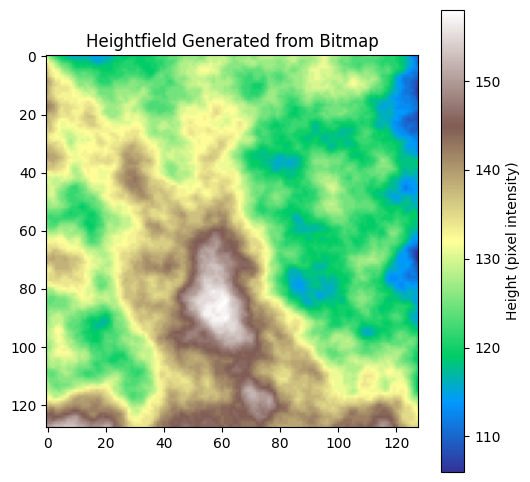

In [ ]:
import cv2
import matplotlib.pyplot as plt

hfield_path = "/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/google_barkour_vb/height_field.png"  # adjust if needed
hfield_img = cv2.imread(hfield_path, cv2.IMREAD_GRAYSCALE)

if hfield_img is None:
    raise FileNotFoundError(f"Could not load image at {hfield_path}")

plt.figure(figsize=(6,6))
plt.imshow(hfield_img, cmap="terrain")
plt.colorbar(label="Height (pixel intensity)")
plt.title("Heightfield Generated from Bitmap")
plt.show()


""

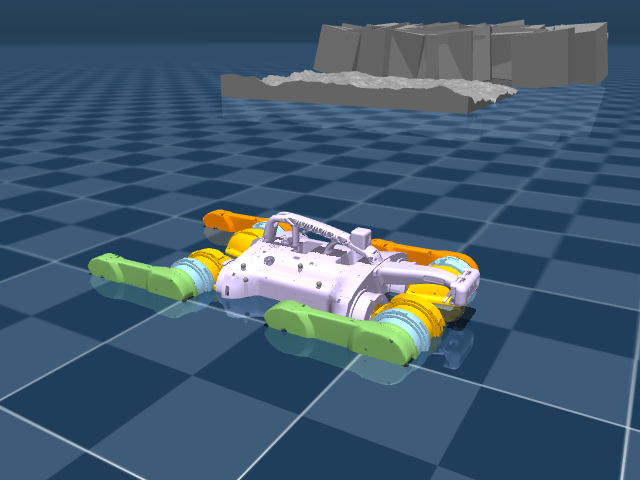

In [12]:
import mujoco
import mediapy as media
import numpy as np

# Load model and data
model = mujoco.MjModel.from_xml_path("/content/drive/MyDrive/CSE598/Lab/lab4-terrain-randomization/google_barkour_vb/scene_mjx_with_terrain.xml")
data = mujoco.MjData(model)

# Create offscreen renderer
# Correct: height first, then width
renderer = mujoco.Renderer(model, 480, 640)


# Step simulation once and render
mujoco.mj_forward(model, data)
renderer.update_scene(data)
pixels = renderer.render()

# Display
media.show_image(pixels)


This idea can actually be extended to more complicated terrains and meshes! See [the terrain-generator repository](https://github.com/leggedrobotics/terrain-generator) for a more detailed implimentation if you're curious!

## Adding a Dynamic Obstacle (Optional / No Credit)

Another thing you may be interested in is adding dynamic object to the scene that the robot can interact with. If interested, take a look at [`pick.py`](https://github.com/google-deepmind/mujoco_playground/blob/main/mujoco_playground/_src/manipulation/franka_emika_panda/pick.py) from the official mujoco_playground repo to figure out how to do this.


Note that you'll have to modify both the environment file `custom_env.py` and the `google_barkour_vb/scene_mjx.xml` file to get this to work!

## What to Turn In

`#TODO(student):` Please zip the following files and turn them into the assignment on gradescope:
1. this `04_lab_student.ipynb` file. Please make sure to fill our your name and umich ID in the first cell
2. the modified `terrain_generator_student.py` file.